# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18, resnet34

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 2000
lr = 1e-7
batch_size = 10
num_workers = 1

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:0')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:0 dtype <class 'torch.cuda.FloatTensor'>


### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0.15] #, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [10]:
continue_ = True # if training same more for more epochs
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
  
    # create model
    if not continue_:
        model = resnet34(drop_prob=drop_prob)
        model = model.to(device)

        # Handle loss function and optimizer
        crit = torch.nn.CrossEntropyLoss()
        opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

        # used to track the loss and accuracy over each epoch
        stats = np.zeros(shape=(num_epoch, 2, 2))
        trained_for = 0
    else:
        temp = stats # stats from previous training
        trained_for = len(temp) # how many epochs the model has trained for
        stats = np.zeros(shape=(trained_for + num_epoch, 2, 2))
        stats[:trained_for, :, :] = temp # save old training data
        
    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1

    # handle training and testing dataloaders
    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[trained_for + epoch, train, loss ] = tr_loss
        stats[trained_for + epoch, train, acc  ] = tr_accuracy
        stats[trained_for + epoch, test,  loss ] = ts_loss
        stats[trained_for + epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.3f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0.15
Epoch:    1 Tr loss: 3.337 Ts loss: 2.716 Tr Accuracy: 8.93% Ts Accuracy: 9.09% Time: 3.39s p=0.15 save!
Epoch:    2 Tr loss: 3.177 Ts loss: 2.645 Tr Accuracy: 9.39% Ts Accuracy: 8.21% Time: 6.11s p=0.15 
Epoch:    3 Tr loss: 3.117 Ts loss: 2.577 Tr Accuracy: 9.51% Ts Accuracy: 11.14% Time: 8.86s p=0.15 save!
Epoch:    4 Tr loss: 2.978 Ts loss: 2.598 Tr Accuracy: 7.45% Ts Accuracy: 8.80% Time: 11.61s p=0.15 
Epoch:    5 Tr loss: 2.905 Ts loss: 2.544 Tr Accuracy: 9.62% Ts Accuracy: 10.56% Time: 14.50s p=0.15 
Epoch:    6 Tr loss: 2.855 Ts loss: 2.524 Tr Accuracy: 8.13% Ts Accuracy: 11.44% Time: 17.24s p=0.15 save!
Epoch:    7 Tr loss: 2.726 Ts loss: 2.502 Tr Accuracy: 10.77% Ts Accuracy: 10.85% Time: 20.00s p=0.15 
Epoch:    8 Tr loss: 2.666 Ts loss: 2.479 Tr Accuracy: 10.88% Ts Accuracy: 10.85% Time: 22.77s p=0.15 
Epoch:    9 Tr loss: 2.575 Ts loss: 2.460 Tr Accuracy: 12.26% Ts Accuracy: 14.66% Time: 25.60s p=0.15 save!
Epoch:   10 Tr loss: 2.549 Ts loss: 2.435 Tr Accu

Epoch:   79 Tr loss: 1.643 Ts loss: 2.097 Tr Accuracy: 40.55% Ts Accuracy: 25.81% Time: 219.55s p=0.15 
Epoch:   80 Tr loss: 1.659 Ts loss: 2.064 Tr Accuracy: 40.55% Ts Accuracy: 30.79% Time: 222.30s p=0.15 
Epoch:   81 Tr loss: 1.626 Ts loss: 2.013 Tr Accuracy: 40.32% Ts Accuracy: 36.66% Time: 225.06s p=0.15 
Epoch:   82 Tr loss: 1.643 Ts loss: 2.031 Tr Accuracy: 38.26% Ts Accuracy: 35.78% Time: 227.94s p=0.15 
Epoch:   83 Tr loss: 1.649 Ts loss: 2.089 Tr Accuracy: 38.03% Ts Accuracy: 32.55% Time: 230.73s p=0.15 
Epoch:   84 Tr loss: 1.645 Ts loss: 2.017 Tr Accuracy: 41.58% Ts Accuracy: 35.78% Time: 233.56s p=0.15 
Epoch:   85 Tr loss: 1.624 Ts loss: 2.017 Tr Accuracy: 40.09% Ts Accuracy: 36.07% Time: 236.33s p=0.15 
Epoch:   86 Tr loss: 1.611 Ts loss: 1.987 Tr Accuracy: 41.58% Ts Accuracy: 37.24% Time: 239.10s p=0.15 save!
Epoch:   87 Tr loss: 1.606 Ts loss: 1.986 Tr Accuracy: 41.92% Ts Accuracy: 36.95% Time: 241.87s p=0.15 
Epoch:   88 Tr loss: 1.584 Ts loss: 2.018 Tr Accuracy: 41.3

Epoch:  158 Tr loss: 1.394 Ts loss: 1.935 Tr Accuracy: 46.62% Ts Accuracy: 32.84% Time: 438.23s p=0.15 
Epoch:  159 Tr loss: 1.386 Ts loss: 1.793 Tr Accuracy: 49.60% Ts Accuracy: 45.75% Time: 440.98s p=0.15 save!
Epoch:  160 Tr loss: 1.390 Ts loss: 1.913 Tr Accuracy: 49.37% Ts Accuracy: 35.78% Time: 443.73s p=0.15 
Epoch:  161 Tr loss: 1.379 Ts loss: 1.880 Tr Accuracy: 49.37% Ts Accuracy: 38.12% Time: 446.47s p=0.15 
Epoch:  162 Tr loss: 1.386 Ts loss: 1.875 Tr Accuracy: 48.80% Ts Accuracy: 36.07% Time: 449.21s p=0.15 
Epoch:  163 Tr loss: 1.379 Ts loss: 1.898 Tr Accuracy: 48.91% Ts Accuracy: 36.36% Time: 451.95s p=0.15 
Epoch:  164 Tr loss: 1.373 Ts loss: 1.804 Tr Accuracy: 50.17% Ts Accuracy: 43.40% Time: 454.75s p=0.15 
Epoch:  165 Tr loss: 1.345 Ts loss: 1.835 Tr Accuracy: 50.52% Ts Accuracy: 41.06% Time: 457.49s p=0.15 
Epoch:  166 Tr loss: 1.343 Ts loss: 1.874 Tr Accuracy: 49.48% Ts Accuracy: 40.47% Time: 460.20s p=0.15 
Epoch:  167 Tr loss: 1.345 Ts loss: 1.852 Tr Accuracy: 50.2

Epoch:  237 Tr loss: 1.245 Ts loss: 1.734 Tr Accuracy: 52.69% Ts Accuracy: 41.06% Time: 654.35s p=0.15 
Epoch:  238 Tr loss: 1.207 Ts loss: 1.787 Tr Accuracy: 56.82% Ts Accuracy: 39.30% Time: 657.09s p=0.15 
Epoch:  239 Tr loss: 1.216 Ts loss: 1.694 Tr Accuracy: 55.67% Ts Accuracy: 44.57% Time: 659.80s p=0.15 
Epoch:  240 Tr loss: 1.185 Ts loss: 1.682 Tr Accuracy: 57.50% Ts Accuracy: 47.21% Time: 662.51s p=0.15 
Epoch:  241 Tr loss: 1.220 Ts loss: 1.628 Tr Accuracy: 54.30% Ts Accuracy: 44.28% Time: 665.23s p=0.15 
Epoch:  242 Tr loss: 1.239 Ts loss: 1.718 Tr Accuracy: 54.87% Ts Accuracy: 43.40% Time: 667.95s p=0.15 
Epoch:  243 Tr loss: 1.220 Ts loss: 1.679 Tr Accuracy: 55.78% Ts Accuracy: 44.28% Time: 670.72s p=0.15 
Epoch:  244 Tr loss: 1.219 Ts loss: 1.768 Tr Accuracy: 56.01% Ts Accuracy: 39.30% Time: 673.47s p=0.15 
Epoch:  245 Tr loss: 1.241 Ts loss: 1.609 Tr Accuracy: 53.38% Ts Accuracy: 50.73% Time: 676.27s p=0.15 save!
Epoch:  246 Tr loss: 1.180 Ts loss: 1.715 Tr Accuracy: 56.9

Epoch:  316 Tr loss: 1.100 Ts loss: 1.608 Tr Accuracy: 59.11% Ts Accuracy: 47.21% Time: 871.15s p=0.15 
Epoch:  317 Tr loss: 1.125 Ts loss: 1.627 Tr Accuracy: 58.65% Ts Accuracy: 46.63% Time: 873.89s p=0.15 
Epoch:  318 Tr loss: 1.111 Ts loss: 1.585 Tr Accuracy: 59.68% Ts Accuracy: 48.39% Time: 876.60s p=0.15 
Epoch:  319 Tr loss: 1.105 Ts loss: 1.591 Tr Accuracy: 60.37% Ts Accuracy: 49.27% Time: 879.31s p=0.15 
Epoch:  320 Tr loss: 1.105 Ts loss: 1.650 Tr Accuracy: 58.99% Ts Accuracy: 46.04% Time: 882.02s p=0.15 
Epoch:  321 Tr loss: 1.078 Ts loss: 1.613 Tr Accuracy: 62.20% Ts Accuracy: 47.51% Time: 884.73s p=0.15 
Epoch:  322 Tr loss: 1.113 Ts loss: 1.595 Tr Accuracy: 58.76% Ts Accuracy: 47.51% Time: 887.52s p=0.15 
Epoch:  323 Tr loss: 1.111 Ts loss: 1.600 Tr Accuracy: 57.96% Ts Accuracy: 47.21% Time: 890.23s p=0.15 
Epoch:  324 Tr loss: 1.095 Ts loss: 1.568 Tr Accuracy: 61.74% Ts Accuracy: 50.73% Time: 893.00s p=0.15 
Epoch:  325 Tr loss: 1.073 Ts loss: 1.688 Tr Accuracy: 60.02% Ts

Epoch:  394 Tr loss: 1.030 Ts loss: 1.495 Tr Accuracy: 62.31% Ts Accuracy: 51.32% Time: 1084.16s p=0.15 
Epoch:  395 Tr loss: 1.018 Ts loss: 1.627 Tr Accuracy: 63.46% Ts Accuracy: 45.16% Time: 1086.97s p=0.15 
Epoch:  396 Tr loss: 1.032 Ts loss: 1.487 Tr Accuracy: 62.43% Ts Accuracy: 51.91% Time: 1089.69s p=0.15 
Epoch:  397 Tr loss: 1.028 Ts loss: 1.493 Tr Accuracy: 63.92% Ts Accuracy: 50.73% Time: 1092.38s p=0.15 
Epoch:  398 Tr loss: 1.041 Ts loss: 1.388 Tr Accuracy: 61.51% Ts Accuracy: 55.43% Time: 1095.07s p=0.15 
Epoch:  399 Tr loss: 1.001 Ts loss: 1.484 Tr Accuracy: 65.52% Ts Accuracy: 51.91% Time: 1097.76s p=0.15 
Epoch:  400 Tr loss: 1.050 Ts loss: 1.504 Tr Accuracy: 62.08% Ts Accuracy: 52.49% Time: 1100.46s p=0.15 
Epoch:  401 Tr loss: 1.027 Ts loss: 1.403 Tr Accuracy: 61.51% Ts Accuracy: 53.67% Time: 1103.15s p=0.15 
Epoch:  402 Tr loss: 1.015 Ts loss: 1.386 Tr Accuracy: 64.60% Ts Accuracy: 56.30% Time: 1105.87s p=0.15 
Epoch:  403 Tr loss: 1.025 Ts loss: 1.518 Tr Accuracy: 

Epoch:  472 Tr loss: 0.950 Ts loss: 1.342 Tr Accuracy: 66.09% Ts Accuracy: 54.84% Time: 1297.60s p=0.15 
Epoch:  473 Tr loss: 0.941 Ts loss: 1.415 Tr Accuracy: 66.32% Ts Accuracy: 54.25% Time: 1300.34s p=0.15 
Epoch:  474 Tr loss: 0.923 Ts loss: 1.286 Tr Accuracy: 67.47% Ts Accuracy: 60.12% Time: 1303.12s p=0.15 
Epoch:  475 Tr loss: 0.953 Ts loss: 1.552 Tr Accuracy: 65.75% Ts Accuracy: 48.09% Time: 1305.86s p=0.15 
Epoch:  476 Tr loss: 0.963 Ts loss: 1.420 Tr Accuracy: 66.55% Ts Accuracy: 54.84% Time: 1308.62s p=0.15 
Epoch:  477 Tr loss: 0.953 Ts loss: 1.373 Tr Accuracy: 67.24% Ts Accuracy: 53.37% Time: 1311.41s p=0.15 
Epoch:  478 Tr loss: 0.949 Ts loss: 1.288 Tr Accuracy: 66.09% Ts Accuracy: 58.06% Time: 1314.20s p=0.15 
Epoch:  479 Tr loss: 0.928 Ts loss: 1.387 Tr Accuracy: 67.12% Ts Accuracy: 54.84% Time: 1316.92s p=0.15 
Epoch:  480 Tr loss: 0.954 Ts loss: 1.314 Tr Accuracy: 66.32% Ts Accuracy: 56.30% Time: 1319.71s p=0.15 
Epoch:  481 Tr loss: 0.938 Ts loss: 1.420 Tr Accuracy: 

Epoch:  550 Tr loss: 0.882 Ts loss: 1.315 Tr Accuracy: 69.64% Ts Accuracy: 58.94% Time: 1510.95s p=0.15 
Epoch:  551 Tr loss: 0.863 Ts loss: 1.224 Tr Accuracy: 69.53% Ts Accuracy: 58.36% Time: 1513.66s p=0.15 
Epoch:  552 Tr loss: 0.859 Ts loss: 1.207 Tr Accuracy: 70.45% Ts Accuracy: 62.17% Time: 1516.36s p=0.15 
Epoch:  553 Tr loss: 0.885 Ts loss: 1.223 Tr Accuracy: 68.73% Ts Accuracy: 59.53% Time: 1519.04s p=0.15 
Epoch:  554 Tr loss: 0.886 Ts loss: 1.259 Tr Accuracy: 68.61% Ts Accuracy: 59.24% Time: 1521.86s p=0.15 
Epoch:  555 Tr loss: 0.889 Ts loss: 1.221 Tr Accuracy: 69.07% Ts Accuracy: 60.41% Time: 1524.57s p=0.15 
Epoch:  556 Tr loss: 0.906 Ts loss: 1.208 Tr Accuracy: 67.47% Ts Accuracy: 62.46% Time: 1527.29s p=0.15 
Epoch:  557 Tr loss: 0.841 Ts loss: 1.309 Tr Accuracy: 69.64% Ts Accuracy: 56.89% Time: 1530.00s p=0.15 
Epoch:  558 Tr loss: 0.859 Ts loss: 1.252 Tr Accuracy: 70.10% Ts Accuracy: 58.06% Time: 1532.72s p=0.15 
Epoch:  559 Tr loss: 0.910 Ts loss: 1.207 Tr Accuracy: 

Epoch:  628 Tr loss: 0.807 Ts loss: 1.109 Tr Accuracy: 72.51% Ts Accuracy: 64.52% Time: 1724.12s p=0.15 
Epoch:  629 Tr loss: 0.821 Ts loss: 1.148 Tr Accuracy: 71.48% Ts Accuracy: 63.93% Time: 1726.87s p=0.15 
Epoch:  630 Tr loss: 0.813 Ts loss: 1.182 Tr Accuracy: 71.36% Ts Accuracy: 63.34% Time: 1729.59s p=0.15 
Epoch:  631 Tr loss: 0.808 Ts loss: 1.194 Tr Accuracy: 70.68% Ts Accuracy: 61.88% Time: 1732.30s p=0.15 
Epoch:  632 Tr loss: 0.787 Ts loss: 1.225 Tr Accuracy: 72.62% Ts Accuracy: 59.24% Time: 1735.04s p=0.15 
Epoch:  633 Tr loss: 0.818 Ts loss: 1.169 Tr Accuracy: 71.59% Ts Accuracy: 62.76% Time: 1737.76s p=0.15 
Epoch:  634 Tr loss: 0.818 Ts loss: 1.162 Tr Accuracy: 70.33% Ts Accuracy: 63.05% Time: 1740.51s p=0.15 
Epoch:  635 Tr loss: 0.812 Ts loss: 1.300 Tr Accuracy: 72.74% Ts Accuracy: 57.18% Time: 1743.23s p=0.15 
Epoch:  636 Tr loss: 0.810 Ts loss: 1.134 Tr Accuracy: 71.71% Ts Accuracy: 65.10% Time: 1745.97s p=0.15 
Epoch:  637 Tr loss: 0.790 Ts loss: 1.148 Tr Accuracy: 

Epoch:  706 Tr loss: 0.774 Ts loss: 1.009 Tr Accuracy: 72.28% Ts Accuracy: 66.57% Time: 1937.71s p=0.15 
Epoch:  707 Tr loss: 0.751 Ts loss: 1.243 Tr Accuracy: 72.62% Ts Accuracy: 57.48% Time: 1940.43s p=0.15 
Epoch:  708 Tr loss: 0.746 Ts loss: 1.219 Tr Accuracy: 75.03% Ts Accuracy: 58.65% Time: 1943.12s p=0.15 
Epoch:  709 Tr loss: 0.748 Ts loss: 1.023 Tr Accuracy: 73.31% Ts Accuracy: 66.28% Time: 1945.88s p=0.15 
Epoch:  710 Tr loss: 0.741 Ts loss: 1.147 Tr Accuracy: 75.95% Ts Accuracy: 62.76% Time: 1948.64s p=0.15 
Epoch:  711 Tr loss: 0.806 Ts loss: 1.001 Tr Accuracy: 71.59% Ts Accuracy: 65.98% Time: 1951.36s p=0.15 
Epoch:  712 Tr loss: 0.786 Ts loss: 1.035 Tr Accuracy: 72.16% Ts Accuracy: 65.40% Time: 1954.05s p=0.15 
Epoch:  713 Tr loss: 0.776 Ts loss: 1.077 Tr Accuracy: 71.59% Ts Accuracy: 65.10% Time: 1956.75s p=0.15 
Epoch:  714 Tr loss: 0.747 Ts loss: 1.031 Tr Accuracy: 74.23% Ts Accuracy: 65.98% Time: 1959.45s p=0.15 
Epoch:  715 Tr loss: 0.750 Ts loss: 1.024 Tr Accuracy: 

Epoch:  784 Tr loss: 0.727 Ts loss: 1.012 Tr Accuracy: 72.97% Ts Accuracy: 65.98% Time: 2151.35s p=0.15 
Epoch:  785 Tr loss: 0.724 Ts loss: 0.899 Tr Accuracy: 75.03% Ts Accuracy: 69.50% Time: 2154.07s p=0.15 
Epoch:  786 Tr loss: 0.729 Ts loss: 0.977 Tr Accuracy: 73.77% Ts Accuracy: 68.33% Time: 2156.87s p=0.15 
Epoch:  787 Tr loss: 0.704 Ts loss: 0.969 Tr Accuracy: 76.40% Ts Accuracy: 68.91% Time: 2159.58s p=0.15 
Epoch:  788 Tr loss: 0.706 Ts loss: 1.009 Tr Accuracy: 76.17% Ts Accuracy: 65.98% Time: 2162.40s p=0.15 
Epoch:  789 Tr loss: 0.707 Ts loss: 0.985 Tr Accuracy: 75.60% Ts Accuracy: 66.28% Time: 2165.09s p=0.15 
Epoch:  790 Tr loss: 0.757 Ts loss: 0.863 Tr Accuracy: 73.42% Ts Accuracy: 73.02% Time: 2167.79s p=0.15 save!
Epoch:  791 Tr loss: 0.681 Ts loss: 0.888 Tr Accuracy: 74.80% Ts Accuracy: 71.26% Time: 2170.51s p=0.15 
Epoch:  792 Tr loss: 0.734 Ts loss: 0.979 Tr Accuracy: 73.88% Ts Accuracy: 68.91% Time: 2173.21s p=0.15 
Epoch:  793 Tr loss: 0.709 Ts loss: 0.995 Tr Accur

Epoch:  862 Tr loss: 0.686 Ts loss: 0.869 Tr Accuracy: 75.83% Ts Accuracy: 70.09% Time: 2364.20s p=0.15 
Epoch:  863 Tr loss: 0.653 Ts loss: 1.028 Tr Accuracy: 77.43% Ts Accuracy: 65.10% Time: 2366.92s p=0.15 
Epoch:  864 Tr loss: 0.646 Ts loss: 0.863 Tr Accuracy: 77.21% Ts Accuracy: 71.26% Time: 2369.70s p=0.15 
Epoch:  865 Tr loss: 0.661 Ts loss: 0.903 Tr Accuracy: 74.80% Ts Accuracy: 70.09% Time: 2372.36s p=0.15 
Epoch:  866 Tr loss: 0.676 Ts loss: 0.985 Tr Accuracy: 76.40% Ts Accuracy: 67.45% Time: 2375.03s p=0.15 
Epoch:  867 Tr loss: 0.659 Ts loss: 0.982 Tr Accuracy: 76.63% Ts Accuracy: 66.28% Time: 2377.83s p=0.15 
Epoch:  868 Tr loss: 0.674 Ts loss: 0.817 Tr Accuracy: 77.43% Ts Accuracy: 73.31% Time: 2380.74s p=0.15 
Epoch:  869 Tr loss: 0.683 Ts loss: 0.935 Tr Accuracy: 75.60% Ts Accuracy: 68.91% Time: 2383.50s p=0.15 
Epoch:  870 Tr loss: 0.662 Ts loss: 0.945 Tr Accuracy: 77.89% Ts Accuracy: 69.21% Time: 2386.28s p=0.15 
Epoch:  871 Tr loss: 0.685 Ts loss: 1.015 Tr Accuracy: 

Epoch:  940 Tr loss: 0.611 Ts loss: 0.855 Tr Accuracy: 79.15% Ts Accuracy: 72.43% Time: 2577.45s p=0.15 
Epoch:  941 Tr loss: 0.606 Ts loss: 0.947 Tr Accuracy: 78.69% Ts Accuracy: 68.91% Time: 2580.16s p=0.15 
Epoch:  942 Tr loss: 0.618 Ts loss: 0.825 Tr Accuracy: 77.89% Ts Accuracy: 71.55% Time: 2582.89s p=0.15 
Epoch:  943 Tr loss: 0.643 Ts loss: 0.893 Tr Accuracy: 77.32% Ts Accuracy: 70.97% Time: 2585.60s p=0.15 
Epoch:  944 Tr loss: 0.617 Ts loss: 0.827 Tr Accuracy: 77.32% Ts Accuracy: 72.43% Time: 2588.34s p=0.15 
Epoch:  945 Tr loss: 0.637 Ts loss: 0.878 Tr Accuracy: 77.21% Ts Accuracy: 70.38% Time: 2591.09s p=0.15 
Epoch:  946 Tr loss: 0.619 Ts loss: 0.803 Tr Accuracy: 78.69% Ts Accuracy: 73.02% Time: 2593.84s p=0.15 
Epoch:  947 Tr loss: 0.620 Ts loss: 0.743 Tr Accuracy: 77.78% Ts Accuracy: 76.83% Time: 2596.56s p=0.15 save!
Epoch:  948 Tr loss: 0.621 Ts loss: 0.796 Tr Accuracy: 77.32% Ts Accuracy: 74.49% Time: 2599.27s p=0.15 
Epoch:  949 Tr loss: 0.646 Ts loss: 0.722 Tr Accur

Epoch: 1018 Tr loss: 0.581 Ts loss: 0.719 Tr Accuracy: 79.84% Ts Accuracy: 74.49% Time: 2790.73s p=0.15 
Epoch: 1019 Tr loss: 0.554 Ts loss: 0.858 Tr Accuracy: 81.90% Ts Accuracy: 71.26% Time: 2793.42s p=0.15 
Epoch: 1020 Tr loss: 0.584 Ts loss: 0.882 Tr Accuracy: 77.43% Ts Accuracy: 70.38% Time: 2796.23s p=0.15 
Epoch: 1021 Tr loss: 0.570 Ts loss: 0.828 Tr Accuracy: 79.27% Ts Accuracy: 71.55% Time: 2798.92s p=0.15 
Epoch: 1022 Tr loss: 0.570 Ts loss: 0.821 Tr Accuracy: 79.84% Ts Accuracy: 71.85% Time: 2801.60s p=0.15 
Epoch: 1023 Tr loss: 0.569 Ts loss: 0.763 Tr Accuracy: 80.53% Ts Accuracy: 74.49% Time: 2804.32s p=0.15 
Epoch: 1024 Tr loss: 0.598 Ts loss: 0.752 Tr Accuracy: 80.18% Ts Accuracy: 74.49% Time: 2807.10s p=0.15 
Epoch: 1025 Tr loss: 0.582 Ts loss: 0.762 Tr Accuracy: 80.76% Ts Accuracy: 74.49% Time: 2809.81s p=0.15 
Epoch: 1026 Tr loss: 0.576 Ts loss: 0.835 Tr Accuracy: 79.73% Ts Accuracy: 71.55% Time: 2812.53s p=0.15 
Epoch: 1027 Tr loss: 0.551 Ts loss: 0.909 Tr Accuracy: 

Epoch: 1096 Tr loss: 0.548 Ts loss: 0.676 Tr Accuracy: 80.41% Ts Accuracy: 76.54% Time: 3004.22s p=0.15 
Epoch: 1097 Tr loss: 0.555 Ts loss: 0.656 Tr Accuracy: 80.87% Ts Accuracy: 77.71% Time: 3006.91s p=0.15 save!
Epoch: 1098 Tr loss: 0.572 Ts loss: 0.783 Tr Accuracy: 78.58% Ts Accuracy: 72.73% Time: 3009.63s p=0.15 
Epoch: 1099 Tr loss: 0.564 Ts loss: 0.760 Tr Accuracy: 79.61% Ts Accuracy: 73.90% Time: 3012.33s p=0.15 
Epoch: 1100 Tr loss: 0.548 Ts loss: 0.823 Tr Accuracy: 80.07% Ts Accuracy: 72.73% Time: 3015.08s p=0.15 
Epoch: 1101 Tr loss: 0.531 Ts loss: 0.705 Tr Accuracy: 81.67% Ts Accuracy: 77.42% Time: 3017.86s p=0.15 
Epoch: 1102 Tr loss: 0.541 Ts loss: 0.708 Tr Accuracy: 82.47% Ts Accuracy: 75.66% Time: 3020.55s p=0.15 
Epoch: 1103 Tr loss: 0.559 Ts loss: 0.805 Tr Accuracy: 79.50% Ts Accuracy: 71.85% Time: 3023.26s p=0.15 
Epoch: 1104 Tr loss: 0.541 Ts loss: 0.780 Tr Accuracy: 80.18% Ts Accuracy: 73.02% Time: 3025.96s p=0.15 
Epoch: 1105 Tr loss: 0.555 Ts loss: 0.785 Tr Accur

Epoch: 1174 Tr loss: 0.499 Ts loss: 0.690 Tr Accuracy: 80.64% Ts Accuracy: 75.95% Time: 3216.81s p=0.15 
Epoch: 1175 Tr loss: 0.498 Ts loss: 0.719 Tr Accuracy: 81.56% Ts Accuracy: 74.78% Time: 3219.50s p=0.15 
Epoch: 1176 Tr loss: 0.534 Ts loss: 0.649 Tr Accuracy: 80.76% Ts Accuracy: 77.42% Time: 3222.18s p=0.15 
Epoch: 1177 Tr loss: 0.509 Ts loss: 0.666 Tr Accuracy: 82.70% Ts Accuracy: 77.13% Time: 3224.88s p=0.15 
Epoch: 1178 Tr loss: 0.529 Ts loss: 0.621 Tr Accuracy: 79.84% Ts Accuracy: 78.01% Time: 3227.61s p=0.15 
Epoch: 1179 Tr loss: 0.520 Ts loss: 0.693 Tr Accuracy: 80.41% Ts Accuracy: 76.54% Time: 3230.32s p=0.15 
Epoch: 1180 Tr loss: 0.511 Ts loss: 0.712 Tr Accuracy: 80.87% Ts Accuracy: 74.78% Time: 3233.08s p=0.15 
Epoch: 1181 Tr loss: 0.533 Ts loss: 0.769 Tr Accuracy: 80.30% Ts Accuracy: 73.31% Time: 3235.77s p=0.15 
Epoch: 1182 Tr loss: 0.516 Ts loss: 0.681 Tr Accuracy: 82.13% Ts Accuracy: 76.54% Time: 3238.74s p=0.15 
Epoch: 1183 Tr loss: 0.511 Ts loss: 0.610 Tr Accuracy: 

Epoch: 1252 Tr loss: 0.511 Ts loss: 0.609 Tr Accuracy: 81.79% Ts Accuracy: 78.59% Time: 3429.72s p=0.15 
Epoch: 1253 Tr loss: 0.476 Ts loss: 0.624 Tr Accuracy: 83.39% Ts Accuracy: 78.89% Time: 3432.47s p=0.15 
Epoch: 1254 Tr loss: 0.489 Ts loss: 0.615 Tr Accuracy: 81.56% Ts Accuracy: 79.18% Time: 3435.32s p=0.15 
Epoch: 1255 Tr loss: 0.495 Ts loss: 0.701 Tr Accuracy: 82.82% Ts Accuracy: 75.07% Time: 3438.02s p=0.15 
Epoch: 1256 Tr loss: 0.516 Ts loss: 0.617 Tr Accuracy: 81.33% Ts Accuracy: 78.01% Time: 3440.75s p=0.15 
Epoch: 1257 Tr loss: 0.470 Ts loss: 0.627 Tr Accuracy: 83.39% Ts Accuracy: 76.83% Time: 3443.47s p=0.15 
Epoch: 1258 Tr loss: 0.517 Ts loss: 0.663 Tr Accuracy: 81.10% Ts Accuracy: 76.54% Time: 3446.19s p=0.15 
Epoch: 1259 Tr loss: 0.531 Ts loss: 0.676 Tr Accuracy: 80.76% Ts Accuracy: 76.25% Time: 3448.93s p=0.15 
Epoch: 1260 Tr loss: 0.515 Ts loss: 0.619 Tr Accuracy: 80.53% Ts Accuracy: 77.71% Time: 3451.67s p=0.15 
Epoch: 1261 Tr loss: 0.517 Ts loss: 0.704 Tr Accuracy: 

Epoch: 1330 Tr loss: 0.472 Ts loss: 0.611 Tr Accuracy: 82.70% Ts Accuracy: 77.71% Time: 3643.10s p=0.15 
Epoch: 1331 Tr loss: 0.479 Ts loss: 0.566 Tr Accuracy: 83.16% Ts Accuracy: 78.89% Time: 3645.87s p=0.15 
Epoch: 1332 Tr loss: 0.453 Ts loss: 0.629 Tr Accuracy: 84.31% Ts Accuracy: 77.42% Time: 3648.55s p=0.15 
Epoch: 1333 Tr loss: 0.476 Ts loss: 0.610 Tr Accuracy: 82.25% Ts Accuracy: 78.01% Time: 3651.27s p=0.15 
Epoch: 1334 Tr loss: 0.465 Ts loss: 0.577 Tr Accuracy: 82.70% Ts Accuracy: 78.01% Time: 3654.01s p=0.15 
Epoch: 1335 Tr loss: 0.491 Ts loss: 0.643 Tr Accuracy: 81.67% Ts Accuracy: 76.25% Time: 3656.74s p=0.15 
Epoch: 1336 Tr loss: 0.493 Ts loss: 0.627 Tr Accuracy: 82.36% Ts Accuracy: 77.13% Time: 3659.56s p=0.15 
Epoch: 1337 Tr loss: 0.458 Ts loss: 0.588 Tr Accuracy: 82.47% Ts Accuracy: 80.35% Time: 3662.28s p=0.15 save!
Epoch: 1338 Tr loss: 0.486 Ts loss: 0.627 Tr Accuracy: 82.13% Ts Accuracy: 76.83% Time: 3665.06s p=0.15 
Epoch: 1339 Tr loss: 0.487 Ts loss: 0.672 Tr Accur

Epoch: 1408 Tr loss: 0.468 Ts loss: 0.576 Tr Accuracy: 83.51% Ts Accuracy: 79.47% Time: 3856.54s p=0.15 
Epoch: 1409 Tr loss: 0.468 Ts loss: 0.547 Tr Accuracy: 80.07% Ts Accuracy: 80.65% Time: 3859.40s p=0.15 save!
Epoch: 1410 Tr loss: 0.449 Ts loss: 0.567 Tr Accuracy: 83.96% Ts Accuracy: 79.47% Time: 3862.17s p=0.15 
Epoch: 1411 Tr loss: 0.449 Ts loss: 0.589 Tr Accuracy: 83.62% Ts Accuracy: 79.77% Time: 3864.98s p=0.15 
Epoch: 1412 Tr loss: 0.445 Ts loss: 0.594 Tr Accuracy: 83.73% Ts Accuracy: 79.18% Time: 3867.73s p=0.15 
Epoch: 1413 Tr loss: 0.439 Ts loss: 0.548 Tr Accuracy: 83.96% Ts Accuracy: 80.06% Time: 3870.46s p=0.15 
Epoch: 1414 Tr loss: 0.444 Ts loss: 0.610 Tr Accuracy: 83.05% Ts Accuracy: 78.01% Time: 3873.17s p=0.15 
Epoch: 1415 Tr loss: 0.454 Ts loss: 0.647 Tr Accuracy: 82.93% Ts Accuracy: 77.42% Time: 3875.94s p=0.15 
Epoch: 1416 Tr loss: 0.462 Ts loss: 0.602 Tr Accuracy: 82.25% Ts Accuracy: 78.59% Time: 3878.63s p=0.15 
Epoch: 1417 Tr loss: 0.443 Ts loss: 0.550 Tr Accur

Epoch: 1486 Tr loss: 0.449 Ts loss: 0.616 Tr Accuracy: 83.51% Ts Accuracy: 77.71% Time: 4069.71s p=0.15 
Epoch: 1487 Tr loss: 0.451 Ts loss: 0.522 Tr Accuracy: 81.79% Ts Accuracy: 81.23% Time: 4072.46s p=0.15 
Epoch: 1488 Tr loss: 0.435 Ts loss: 0.554 Tr Accuracy: 83.96% Ts Accuracy: 80.65% Time: 4075.19s p=0.15 
Epoch: 1489 Tr loss: 0.457 Ts loss: 0.556 Tr Accuracy: 82.36% Ts Accuracy: 78.89% Time: 4077.91s p=0.15 
Epoch: 1490 Tr loss: 0.417 Ts loss: 0.577 Tr Accuracy: 83.51% Ts Accuracy: 78.89% Time: 4080.62s p=0.15 
Epoch: 1491 Tr loss: 0.455 Ts loss: 0.540 Tr Accuracy: 81.90% Ts Accuracy: 80.06% Time: 4083.37s p=0.15 
Epoch: 1492 Tr loss: 0.443 Ts loss: 0.477 Tr Accuracy: 83.73% Ts Accuracy: 82.40% Time: 4086.11s p=0.15 
Epoch: 1493 Tr loss: 0.421 Ts loss: 0.581 Tr Accuracy: 85.11% Ts Accuracy: 79.47% Time: 4088.92s p=0.15 
Epoch: 1494 Tr loss: 0.474 Ts loss: 0.513 Tr Accuracy: 82.59% Ts Accuracy: 81.23% Time: 4091.73s p=0.15 
Epoch: 1495 Tr loss: 0.421 Ts loss: 0.552 Tr Accuracy: 

Epoch: 1564 Tr loss: 0.415 Ts loss: 0.530 Tr Accuracy: 84.42% Ts Accuracy: 80.06% Time: 4283.71s p=0.15 
Epoch: 1565 Tr loss: 0.411 Ts loss: 0.529 Tr Accuracy: 85.45% Ts Accuracy: 80.65% Time: 4286.48s p=0.15 
Epoch: 1566 Tr loss: 0.433 Ts loss: 0.669 Tr Accuracy: 83.51% Ts Accuracy: 75.37% Time: 4289.21s p=0.15 
Epoch: 1567 Tr loss: 0.458 Ts loss: 0.521 Tr Accuracy: 81.90% Ts Accuracy: 80.06% Time: 4291.91s p=0.15 
Epoch: 1568 Tr loss: 0.428 Ts loss: 0.598 Tr Accuracy: 84.19% Ts Accuracy: 78.01% Time: 4294.67s p=0.15 
Epoch: 1569 Tr loss: 0.418 Ts loss: 0.623 Tr Accuracy: 83.39% Ts Accuracy: 76.83% Time: 4297.42s p=0.15 
Epoch: 1570 Tr loss: 0.424 Ts loss: 0.522 Tr Accuracy: 84.19% Ts Accuracy: 80.06% Time: 4300.28s p=0.15 
Epoch: 1571 Tr loss: 0.407 Ts loss: 0.488 Tr Accuracy: 84.42% Ts Accuracy: 81.23% Time: 4303.02s p=0.15 
Epoch: 1572 Tr loss: 0.459 Ts loss: 0.468 Tr Accuracy: 83.62% Ts Accuracy: 82.99% Time: 4305.70s p=0.15 
Epoch: 1573 Tr loss: 0.441 Ts loss: 0.548 Tr Accuracy: 

Epoch: 1642 Tr loss: 0.430 Ts loss: 0.514 Tr Accuracy: 82.36% Ts Accuracy: 80.94% Time: 4496.73s p=0.15 
Epoch: 1643 Tr loss: 0.452 Ts loss: 0.507 Tr Accuracy: 82.47% Ts Accuracy: 80.06% Time: 4499.45s p=0.15 
Epoch: 1644 Tr loss: 0.429 Ts loss: 0.469 Tr Accuracy: 84.65% Ts Accuracy: 82.70% Time: 4502.16s p=0.15 
Epoch: 1645 Tr loss: 0.422 Ts loss: 0.519 Tr Accuracy: 82.93% Ts Accuracy: 80.35% Time: 4504.89s p=0.15 
Epoch: 1646 Tr loss: 0.408 Ts loss: 0.546 Tr Accuracy: 84.31% Ts Accuracy: 80.35% Time: 4507.56s p=0.15 
Epoch: 1647 Tr loss: 0.433 Ts loss: 0.446 Tr Accuracy: 83.85% Ts Accuracy: 82.70% Time: 4510.29s p=0.15 
Epoch: 1648 Tr loss: 0.408 Ts loss: 0.483 Tr Accuracy: 85.80% Ts Accuracy: 82.11% Time: 4512.96s p=0.15 
Epoch: 1649 Tr loss: 0.415 Ts loss: 0.471 Tr Accuracy: 83.05% Ts Accuracy: 82.70% Time: 4515.65s p=0.15 
Epoch: 1650 Tr loss: 0.445 Ts loss: 0.477 Tr Accuracy: 84.19% Ts Accuracy: 81.82% Time: 4518.32s p=0.15 
Epoch: 1651 Tr loss: 0.405 Ts loss: 0.485 Tr Accuracy: 

Epoch: 1720 Tr loss: 0.387 Ts loss: 0.485 Tr Accuracy: 84.77% Ts Accuracy: 82.11% Time: 4709.42s p=0.15 
Epoch: 1721 Tr loss: 0.390 Ts loss: 0.493 Tr Accuracy: 85.57% Ts Accuracy: 81.52% Time: 4712.11s p=0.15 
Epoch: 1722 Tr loss: 0.400 Ts loss: 0.465 Tr Accuracy: 84.88% Ts Accuracy: 82.40% Time: 4714.81s p=0.15 
Epoch: 1723 Tr loss: 0.428 Ts loss: 0.452 Tr Accuracy: 84.42% Ts Accuracy: 82.11% Time: 4717.50s p=0.15 
Epoch: 1724 Tr loss: 0.378 Ts loss: 0.548 Tr Accuracy: 84.77% Ts Accuracy: 80.65% Time: 4720.24s p=0.15 
Epoch: 1725 Tr loss: 0.388 Ts loss: 0.477 Tr Accuracy: 84.77% Ts Accuracy: 81.82% Time: 4723.01s p=0.15 
Epoch: 1726 Tr loss: 0.420 Ts loss: 0.460 Tr Accuracy: 84.08% Ts Accuracy: 82.99% Time: 4725.79s p=0.15 
Epoch: 1727 Tr loss: 0.395 Ts loss: 0.529 Tr Accuracy: 84.77% Ts Accuracy: 81.52% Time: 4728.53s p=0.15 
Epoch: 1728 Tr loss: 0.382 Ts loss: 0.499 Tr Accuracy: 84.08% Ts Accuracy: 81.82% Time: 4731.25s p=0.15 
Epoch: 1729 Tr loss: 0.414 Ts loss: 0.484 Tr Accuracy: 

Epoch: 1798 Tr loss: 0.374 Ts loss: 0.479 Tr Accuracy: 86.03% Ts Accuracy: 82.70% Time: 4922.51s p=0.15 
Epoch: 1799 Tr loss: 0.385 Ts loss: 0.426 Tr Accuracy: 84.54% Ts Accuracy: 84.16% Time: 4925.21s p=0.15 
Epoch: 1800 Tr loss: 0.407 Ts loss: 0.482 Tr Accuracy: 84.88% Ts Accuracy: 80.94% Time: 4927.90s p=0.15 
Epoch: 1801 Tr loss: 0.367 Ts loss: 0.451 Tr Accuracy: 86.60% Ts Accuracy: 83.87% Time: 4930.59s p=0.15 
Epoch: 1802 Tr loss: 0.390 Ts loss: 0.477 Tr Accuracy: 86.71% Ts Accuracy: 81.82% Time: 4933.28s p=0.15 
Epoch: 1803 Tr loss: 0.368 Ts loss: 0.484 Tr Accuracy: 86.25% Ts Accuracy: 82.11% Time: 4935.98s p=0.15 
Epoch: 1804 Tr loss: 0.369 Ts loss: 0.501 Tr Accuracy: 86.03% Ts Accuracy: 81.23% Time: 4938.68s p=0.15 
Epoch: 1805 Tr loss: 0.369 Ts loss: 0.477 Tr Accuracy: 85.45% Ts Accuracy: 82.99% Time: 4941.38s p=0.15 
Epoch: 1806 Tr loss: 0.388 Ts loss: 0.489 Tr Accuracy: 85.22% Ts Accuracy: 82.11% Time: 4944.09s p=0.15 
Epoch: 1807 Tr loss: 0.377 Ts loss: 0.489 Tr Accuracy: 

Epoch: 1876 Tr loss: 0.349 Ts loss: 0.471 Tr Accuracy: 85.80% Ts Accuracy: 82.40% Time: 5135.06s p=0.15 
Epoch: 1877 Tr loss: 0.372 Ts loss: 0.466 Tr Accuracy: 85.68% Ts Accuracy: 82.11% Time: 5137.76s p=0.15 
Epoch: 1878 Tr loss: 0.379 Ts loss: 0.501 Tr Accuracy: 85.91% Ts Accuracy: 81.52% Time: 5140.53s p=0.15 
Epoch: 1879 Tr loss: 0.358 Ts loss: 0.467 Tr Accuracy: 86.48% Ts Accuracy: 82.99% Time: 5143.31s p=0.15 
Epoch: 1880 Tr loss: 0.379 Ts loss: 0.466 Tr Accuracy: 85.45% Ts Accuracy: 82.11% Time: 5146.14s p=0.15 
Epoch: 1881 Tr loss: 0.363 Ts loss: 0.450 Tr Accuracy: 86.60% Ts Accuracy: 83.28% Time: 5148.84s p=0.15 
Epoch: 1882 Tr loss: 0.368 Ts loss: 0.485 Tr Accuracy: 86.48% Ts Accuracy: 82.11% Time: 5151.55s p=0.15 
Epoch: 1883 Tr loss: 0.371 Ts loss: 0.454 Tr Accuracy: 86.83% Ts Accuracy: 82.11% Time: 5154.34s p=0.15 
Epoch: 1884 Tr loss: 0.397 Ts loss: 0.480 Tr Accuracy: 84.77% Ts Accuracy: 82.11% Time: 5157.02s p=0.15 
Epoch: 1885 Tr loss: 0.375 Ts loss: 0.489 Tr Accuracy: 

Epoch: 1954 Tr loss: 0.338 Ts loss: 0.419 Tr Accuracy: 87.51% Ts Accuracy: 83.28% Time: 5347.92s p=0.15 
Epoch: 1955 Tr loss: 0.338 Ts loss: 0.438 Tr Accuracy: 87.06% Ts Accuracy: 83.58% Time: 5350.64s p=0.15 
Epoch: 1956 Tr loss: 0.395 Ts loss: 0.431 Tr Accuracy: 84.77% Ts Accuracy: 83.58% Time: 5353.37s p=0.15 
Epoch: 1957 Tr loss: 0.386 Ts loss: 0.451 Tr Accuracy: 85.11% Ts Accuracy: 83.28% Time: 5356.12s p=0.15 
Epoch: 1958 Tr loss: 0.349 Ts loss: 0.465 Tr Accuracy: 86.83% Ts Accuracy: 83.28% Time: 5358.90s p=0.15 
Epoch: 1959 Tr loss: 0.358 Ts loss: 0.465 Tr Accuracy: 86.83% Ts Accuracy: 82.70% Time: 5361.63s p=0.15 
Epoch: 1960 Tr loss: 0.365 Ts loss: 0.479 Tr Accuracy: 86.37% Ts Accuracy: 82.40% Time: 5364.35s p=0.15 
Epoch: 1961 Tr loss: 0.343 Ts loss: 0.467 Tr Accuracy: 86.71% Ts Accuracy: 82.11% Time: 5367.08s p=0.15 
Epoch: 1962 Tr loss: 0.371 Ts loss: 0.415 Tr Accuracy: 85.45% Ts Accuracy: 84.75% Time: 5369.78s p=0.15 
Epoch: 1963 Tr loss: 0.367 Ts loss: 0.431 Tr Accuracy: 

In [11]:
print(best_acc)

85.92375366568915


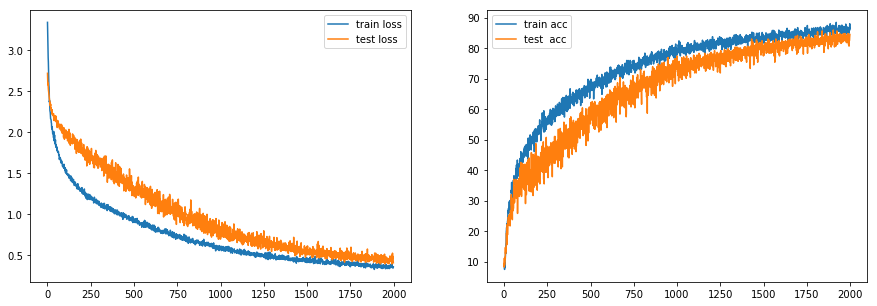

In [12]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()

In [13]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

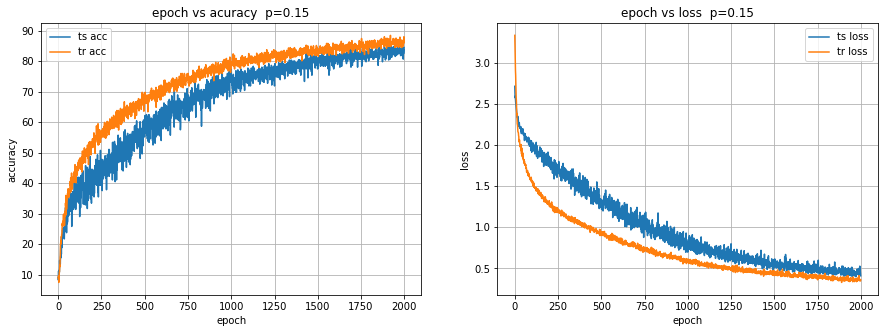

In [14]:
train = 0
test  = 1
acc   = 0
loss  = 1

x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[i,:,test,acc]
    ts_l = test_file[i,:,test,loss]
    tr_a = test_file[i,:,train,acc]
    tr_l = test_file[i,:,train,loss]
    
    plt.plot(x,ts_a,label='ts acc')
    plt.plot(x,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x,ts_l,label='ts loss')
    plt.plot(x,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    